In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
spy = yf.Ticker('SPY')
hist = spy.history(period = '5y')
pers = hist.loc[:,'Close'].apply(np.log).diff(1)

In [ ]:
def sma(prices, period):
    return prices.loc[:,'Close'].rolling(window=period).mean()

In [ ]:
sma50 = sma(hist,50).fillna(0).shift(periods=1, fill_value=0)
sma50[:200] = 0
sma200 = sma(hist,200).fillna(0).shift(periods=1,fill_value=0)
signal = sma50 - sma200
sig = signal.apply(np.sign)

In [ ]:
returns = sig * pers
print(returns.cumsum().apply(np.exp))

In [ ]:
prices = hist.loc[:,'Close'].to_numpy()
running_sma50 = prices[150:200].mean()
running_sma200 = prices[:200].mean()

In [ ]:
event = 0
rets = [0]
for i in range(200, hist.shape[0]):
    rets.append(rets[-1] + (event * (pers.iloc[i])))
    running_sma50+=(prices[i] - prices[i-50])/50
    running_sma200+=(prices[i] - prices[i-200])/200
    event = np.sign(running_sma50 - running_sma200)

,0
0,223.709061
1,224.231689
2,224.240875
3,224.497589
4,225.561142
...,...
1253,426.649994
1254,427.890015
1255,422.140015
1256,413.350006


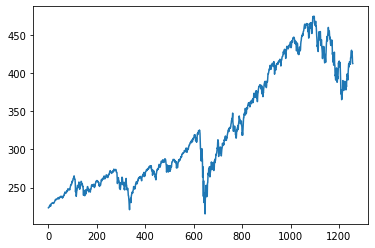

In [30]:
plt.plot(pd.DataFrame(prices))

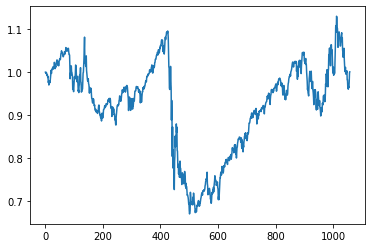

In [28]:
plt.plot(np.exp(rets))

In [ ]:
from blankly import Alpaca, Interface, Strategy, StrategyState
from blankly.indicators import sma

def init(symbol, state: StrategyState):
    interface: Interface = state.interface
    resolution: float = state.resolution
    variables = state.variables
    # initialize the historical data
    variables["history"] = interface.history(symbol, 800, resolution, return_as='deque')["close"]
    variables["has_bought"] = False

def price_event(price, symbol, state: StrategyState):
    interface: Interface = state.interface
    # allow the resolution to be any resolution: 15m, 30m, 1d, etc.
    resolution: float = state.resolution
    variables = state.variables

    variables["history"].append(price)

    sma200 = sma(variables["history"], period=20)
    sma50 = sma(variables["history"], period=10)[-len(sma200):]
    diff = sma200 - sma50
    slope_sma50 = (
        sma50[-1] - sma50[-5]
    ) / 5  # get the slope of the last 5 SMA50 Data Points
    prev_diff = diff[-2]
    curr_diff = diff[-1]
    is_cross_up = slope_sma50 > 0 and curr_diff >= 0 and prev_diff < 0
    is_cross_down = slope_sma50 < 0 and curr_diff <= 0 and prev_diff > 0
    # comparing prev diff with current diff will show a cross
    if is_cross_up and not variables["has_bought"]:
        interface.market_order(symbol, 'buy', int(interface.cash / price))
        variables["has_bought"] = True
    elif is_cross_down and variables["has_bought"]:
        interface.market_order(
            symbol, 'sell', int(interface.account[symbol].available)
        )
        variables["has_bought"] = False

if __name__ == "__main__":
    alpaca = Alpaca()
    s = Strategy(alpaca)
    s.add_price_event(price_event, "MSFT", resolution="1d", init=init)
    s.add_price_event(price_event, "AAPL", resolution="1d", init=init)
    s.backtest(initial_values={"USD": 10000}, to="2y")